# Tutorial Notebooks
This is the fourth (and final for now) in a series of how-to notebooks that walk through producing simulated slitless spectroscopy images using Grizli. This notebook will walk through producing a simulated slitless spectrospy image from a direct image.

It's worth acknowledging that there is another process that will produce this model. However, that process requires setting up a seperate conda environment and installing an old version of Photutils. Additionally, if the padding is too small and an object cannot be dispersed, the alternate process will not throw any warnings, whereas the process in this notebook will. For those reasons, the alternate process is not demonstrated in this tutorial series.

## Steps/Cells
1) Imports
2) Segmentation Image
3) Produce the model image
4) Display the image
5) Save the Image

#### 1) Imports

In [1]:
# General imports
import os
import numpy as np
import matplotlib.pyplot as plt

# Segmentation process
from astropy.io import fits
from photutils.segmentation import SourceFinder, make_2dgaussian_kernel, SourceCatalog
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve

# grizli
from grizli.model import GrismFLT
import grizli

# Work in fits_files directory to make our files easy to access
os.chdir("/Users/keith/astr/research_astr/summer-roman-project/tutorial/fits_files")

# Define what direct image to use and what to save our segmentation image as
direct_file = "Rotated_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
seg_file = "seg.fits"

#### 2) Segmentation Image

In [2]:
# Process direct image and produce segmentation map

# Open image
direct_fits = fits.open(direct_file)
data, header = direct_fits[1].data, direct_fits[1].header

# Subtract background
bkg_estimator = MedianBackground()
bkg = Background2D(data, (511,511), filter_size=(3,3), bkg_estimator=bkg_estimator)
data -= bkg.background

# Convolve image
kernel = make_2dgaussian_kernel(3.0, 5)
convolved_data = convolve(data, kernel)

# Instantiate the SourceFinder and set threshold
finder = SourceFinder(npixels=7, nlevels=32, contrast=0.001)
threshold = 2 * bkg.background_rms

seg_map = finder(convolved_data, threshold)

# Save seg_map as fits
fits.writeto(seg_file, seg_map, header=header,overwrite=True)

Deblending:   0%|          | 0/6281 [00:00<?, ?it/s]

#### 3) Produce the model image

Two likely pitfalls in this cell:
1) Incorrect Padding: If the padding is too small, Grizli will not be able to find objects near the edges of the image. This will print "ID ## not found in segmentation image." Current reccomendation is size=100.

2) Incorrect Size: If the size is too small, Grizli will not have room for the dispersion trace in a given objects cutout. If the size is too large, compute times will be excessive. If size is passed to compute_full_model, you must also pass compute_size=False; otherwise, the passed in size will be ignored. Current reccomendation is using the Scipy Optimize process from notebook 3_fits_files.ipynb.

In [3]:
# Instantiate the GrismFLT object
pad = 100
roman_sim = GrismFLT(direct_file=direct_file, seg_file=seg_file, pad=pad)
roman_sim.compute_full_model(mag_limit=28, size=77, compute_size=False)



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
Rotated_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
Rotated_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


#### 4) Display the image

Text(0.5, 1.0, 'Simulated Grism Image')

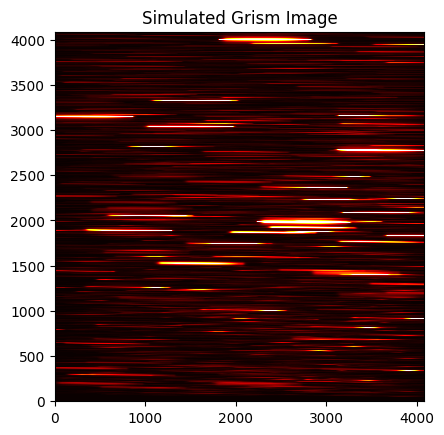

In [4]:
fig, ax = plt.subplots()
ax.imshow(roman_sim.model[pad:-pad, pad:-pad]/np.max(roman_sim.model), interpolation='Nearest', 
           origin='lower', vmin=0., vmax=0.015, cmap='hot')
ax.set_title("Simulated Grism Image")


#### 5) Save the Image

In [5]:
fits.writeto("full_model.fits", roman_sim.model[pad:-pad, pad:-pad], header=header, overwrite=True)